# Circuit for state preparation

We want to create a circuit that produces the Bell state $\vert\Phi^+\rangle = \dfrac{\vert00\rangle + \vert11\rangle}{\sqrt 2}$. We already know that this state can be produced by a circuit containing a Hadamard gate on the first qubit followed by a CNOT gate [[1](https://en.wikipedia.org/wiki/Bell_state#Creating_Bell_states)], but we would like to replace the Hadamard gate with rotation gates.

In the following we will use [PennyLane](https://pennylane.readthedocs.io/), a cross-platform Python library for quantum machine learning, because it abstracts away several implementation details (especially when it comes to using different quantum simulators and frameworks such as pyQuil/Forest). PennyLane ships with its own version of NumPy, enriched to include [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) - which lets the gradients on the circuits be computed in a more efficient way using clever transformations. I will also highlight my contributions to the library: the `SquaredErrorLoss` class.

Please read the README.md file to prepare the environment in order to execute this notebook.

### Importing the library

In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.qnn.cost import SquaredErrorLoss

### Circuit definition

First of all, we create the "ansatz" circuit. By doing this we can reuse the same configuration in different circuits, for instance if all we want to change is the measurement.

Since we want to tackle the general case, we put both kinds of the allowed rotation gates on both qubits; then, we also add a CNOT gate. We will therefore have 4 different parameters, each corresponding to a different angle.

In [2]:
def circuit(angles, **kwargs):
    qml.RX(angles[0], wires=0)
    qml.RY(angles[1], wires=0)

    qml.RX(angles[2], wires=1)
    qml.RY(angles[3], wires=1)

    qml.CNOT(wires=[0, 1])

In order to create a circuit, we need to include a _device_ and a _measurement_. For starting out we can use PennyLane's "default qubit" device, which can simulate a real quantum device with any number of wires; see the last section for a list of possible devices. We set `analytic=False` and `shots=1000` to simulate a more realistic device.

In [24]:
dev = qml.device('default.qubit', wires=2, analytic=False, shots=1000)

# For QVM simulation (needs `qvm` and `quilc`, see README)
# dev = qml.device('forest.qvm', device='Aspen-8', shots=100, noisy=True)

# For the real QPU
# dev = qml.device('forest.qpu', device='Aspen-8', shots=100)

# For a list of all the devices supported by the Forest SDK:
#
# from pyquil import list_quantum_computers
# sorted(list_quantum_computers())

# To check the capabilities of a device:
#
# dev.capabilities()

Then, we create a list with one `PauliZ` _observable_ that we will use for the measurement.

In [4]:
observables = [qml.PauliZ(0)]

Now we can initialize some parameters (the gates' angles) and "execute" the circuit, using the expectation value of the observables as a measurement. The `measure` argument default for `qml.map` is already `'expval'`, so here it is added just for clarity.

In [5]:
params = [0.2, 0.8, 0.4, 0.1]
qnode = qml.map(circuit, observables, dev, measure='expval')
print(qnode(params))

[0.652]


The problem of measuring only one qubit is that, in our case where we have an entangled state, such measurement would affect the other qubit as well by "assigning" it the same value. For this reason, we need to measure the 2 qubits together instead.

We can use different combinations of observables:

- combined observables: `[qml.PauliZ(0), qml.PauliZ(1)]` (returns two values);
- tensor product observables: `[qml.PauliZ(0) @ qml.PauliZ(1)]` (returns one value);
- generic Hermitian observables: `[qml.Hermitian(observable, wires=[0, 1])]` (returns one value).

The latter is the most flexible, and since it is supported not only by [PennyLane](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.Hermitian.html) but also by other frameworks (e.g. [Forest](http://docs.rigetti.com/en/stable/apidocs/pauli.html#pyquil.paulis.PauliSum) supports sums of Pauli operators, and [Qiskit](https://qiskit.org/textbook/ch-gates/fun-matrices.html#Pauli-decomposition) explains how to do it), we can make use of it.

We start with defining our target state $\vert\psi\rangle = \dfrac{1}{\sqrt 2} \left[\begin{matrix}1\\0\\0\\1\end{matrix}\right]$:

In [6]:
psi = 1. / np.sqrt(2) * np.array([[1, 0, 0, 1]]).T

Now let's construct the observable as the outer product $O = \vert\psi\rangle \langle\psi\vert$ of the state with itself: 

In [7]:
obs = psi @ psi.conj().T
print(obs)

[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


Why do we "like" this matrix? Because, when used for measurements, it will "boost" the states that have close values for their first and last element. In fact, we have that obviously $\langle\psi\vert O \vert\psi\rangle = 1$:

In [8]:
print(psi.T @ obs @ psi)

[[1.]]


and a vector $\tilde\psi$ close to $\psi$ will have a measurement close to 1:

In [9]:
psi_tilde = psi - 0.001

# For normalization
psi_tilde[1:3] = np.sqrt(0.5 - psi_tilde[0] ** 2)
assert np.allclose(np.linalg.norm(psi_tilde), 1.0)

print(psi_tilde.T @ obs @ psi_tilde)

[[0.99717357]]


Let's also verify whether the observable matrix is Hermitian by checking that it is equal to its own adjunct, i.e. $M = M^\dagger$:

In [10]:
print(np.allclose(obs, obs.conj().T))

True


We can also check whether the matrix can be decomposed as a linear combination of Pauli operators tensor products:

$O = \dfrac{1}{4}((I \otimes I) + (X \otimes X) - (Y \otimes Y) + (Z \otimes Z))$

This step has to be performed manually, but my contribution for a decomposition method is [in progress](https://github.com/XanaduAI/pennylane/pull/671).

In [11]:
# Manually-defined Pauli operators. They can also be derived from PennyLane observables,
# e.g. PauliX = qml.PauliX(0).matrix

identity = np.eye(2)
pauliX = np.array([[0, 1], [1, 0]])
pauliY = np.array([[0, -1j], [1j, 0]])
pauliZ = np.array([[1, 0], [0, -1]])

decomp = 0.25 * np.sum([
    np.kron(identity, identity),
    np.kron(pauliX, pauliX),
    -np.kron(pauliY, pauliY),
    np.kron(pauliZ, pauliZ)
], axis=0)

# Is the decomposed matrix the same as the observable matrix we created before?
print(np.allclose(obs, decomp))

True


Now we are ready to run the circuit again using the new observable:

In [12]:
observables = [qml.Hermitian(obs, wires=[0, 1])]

qnode = qml.map(circuit, observables, dev, measure='expval')
print(qnode(params))

[0.817]


### Optimization

Since the circuit optimization has to be performed via gradient descent, we need first of all a good choice for the initial parameters. We can try a few different ones, including:

- all parameters = 0;
- all parameters randomly chosen;
- parameters initialized to some chosen "sensible" defaults.

In [13]:
params_init_method = 'chosen'

if params_init_method == 'zero':
    params = np.array([0.] * 4)
elif params_init_method == 'random':
    import random
    
    random.seed(0)
    params = np.random.normal(0., np.pi, 4)
elif params_init_method == 'chosen':
    params = np.array([np.pi / 4] * 4)
else:
    raise ValueError('{} initialization method does not exist'.format(weight_init_method))

Then, we need to decide how many optimization steps we will run:

In [14]:
steps = 1000

We also create an additional array that will collect the learned parameters per round:

In [15]:
params_history = np.zeros((4, steps))

We define the cost function as the square of the difference between the value of the observable (which can be between 0 and 1) and 1; this means that the closer the observable gets to one, the smaller the cost becomes.

My contribution is the `SquaredErrorLoss` class, which gives an easy way to calculate the loss given a target.

In [16]:
loss = SquaredErrorLoss(circuit, observables, dev)

def cost(params):
    return loss(params, target=[1])

Finally, we define the optimizer that we will use in the optimization process. We can start with the simplest `qml.GradientDescentOptimizer`, and optionally try a more advanced optimizer such as `qml.AdamOptimizer`:

In [17]:
# opt = qml.GradientDescentOptimizer(stepsize=0.1)
opt = qml.AdamOptimizer(stepsize=0.1)

We are ready to kick off the experiments! It might take a while with the default parameters :)

In [18]:
for i in range(steps):
    params = opt.step(cost, params)

    if i == 0:
        print(f'\tCost after step {i:4d}: {cost(params)[0]: .7f} ({params})')
    elif (i + 1) % 50 == 0:
        print(f'\tCost after step {i+1:4d}: {cost(params)[0]: .7f} ({params})')

    params_history[:, i] = params

result = qml.map(circuit, observables, dev)(params)

print('Optimized parameters: {}'.format(params))
print('Result: {}'.format(result))

try:
    print('Output state: {}'.format(np.round(dev.state, decimals=3)))
except NotImplementedError:
    print('Cannot see state when using device ' + dev.name)

	Cost after step    0:  0.1296000 ([0.68539817 0.88539816 0.68539817 0.68539817])
	Cost after step   50:  0.0000090 ([-0.03293147  1.60377176 -0.03353614 -0.06820349])
	Cost after step  100:  0.0000160 ([-0.03829073  1.60886276 -0.03837615 -0.07078707])
	Cost after step  150:  0.0000040 ([-0.03496846  1.60523443 -0.03451667 -0.06311863])
	Cost after step  200:  0.0000010 ([-0.03236385  1.6020201  -0.03114057 -0.05633291])
	Cost after step  250:  0.0000000 ([-0.02880039  1.59907173 -0.02765732 -0.04897139])
	Cost after step  300:  0.0000040 ([-0.02603434  1.59632197 -0.02553592 -0.04260873])
	Cost after step  350:  0.0000000 ([-0.022509    1.5938294  -0.02349142 -0.03569332])
	Cost after step  400:  0.0000000 ([-0.01884457  1.58985536 -0.02053278 -0.02921451])
	Cost after step  450:  0.0000010 ([-0.01634581  1.58801731 -0.01789411 -0.02474091])
	Cost after step  500:  0.0000000 ([-0.01532654  1.58558383 -0.01484322 -0.02220234])
	Cost after step  550:  0.0000000 ([-0.01353334  1.5839306

### Evaluation

Let's check the results of the last step of the last optimization:

In [19]:
print(params_history[:, -1])

[-0.00623064  1.57346107 -0.00747438 -0.00445746]


We can see that each row shows values around $\left[\begin{matrix}0&\dfrac{\pi}{2}&0&0\end{matrix}\right]$, corresponding to the following rotations:

- $R_x(\phi) = \left[\begin{matrix}cos(\phi/2)&-i sin(\phi/2)\\-i sin(\phi/2)&cos(\phi/2)\end{matrix}\right] \implies R_x(0) = \left[\begin{matrix}1&0\\0&1\end{matrix}\right]$
- $R_y(\phi) = \left[\begin{matrix}cos(\phi/2)&-sin(\phi/2)\\sin(\phi/2)&cos(\phi/2)\end{matrix}\right] \implies R_y(0) = \left[\begin{matrix}1&0\\0&1\end{matrix}\right], R_y(\pi/2) = \dfrac{1}{\sqrt{2}}\left[\begin{matrix}1&-1\\1&1\end{matrix}\right]$

This means that only a $\dfrac{\pi}{2}$ Y-rotation should be applied on the first qubit, while the second qubit should be left unchanged.

### Visualization

In this section we will see the calculated values across runs for every parameter. We will plot the points using `matplotlib`.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'RY(1)')

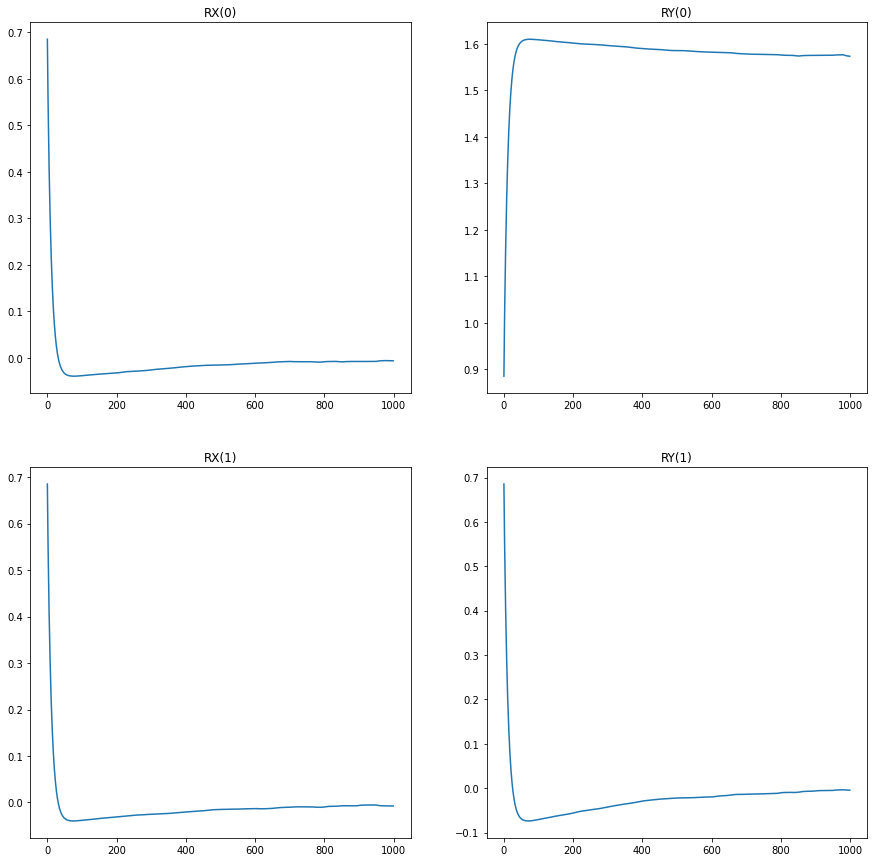

In [21]:
# TODO: can be simplified
fig, axs = plt.subplots(2, 2, figsize=(15,15))

axs[0, 0].plot(params_history[0, :])
axs[0, 0].set_title('RX(0)')

axs[0, 1].plot(params_history[1, :])
axs[0, 1].set_title('RY(0)')

axs[1, 0].plot(params_history[2, :])
axs[1, 0].set_title('RX(1)')    

axs[1, 1].plot(params_history[3, :])
axs[1, 1].set_title('RY(1)')